In this notebook you can reproduce the simulation figures to test the PCA denoising algorithm in a 9 fiber phantom with uncorrelated noise. Here, results are plotted for two quantities reconstructed using the diffusional kurtosis imaging model (DKI).

Let's import the relevant modules for these simulations.

In [1]:
import numpy as np
import math as mt
import matplotlib
import matplotlib.pyplot as plt
from time import time

from scipy.linalg import eigh
from scipy.ndimage import gaussian_filter

import dipy.reconst.dki as dki
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.data import get_sphere, get_fnames
from dipy.core.gradients import gradient_table
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import peaks_from_model

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from dipy.viz import window, actor

<frozen importlib._bootstrap>:219: RuntimeWarning: dipy.direction.pmf.PmfGen size changed, may indicate binary incompatibility. Expected 440 from C header, got 448 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: dipy.direction.pmf.SimplePmfGen size changed, may indicate binary incompatibility. Expected 440 from C header, got 448 from PyObject


In [2]:
sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(n=3)
sphere.vertices.size

138630

The cells below contains the new parts of the code produced for this project, including:

<ins>1) Functions to assess the performance of denoising </ins>

In [3]:
def mp_distribution(x, var, y):
    """ Samples the Marchenko–Pastur probability distribution
    Parameters
    ----------
    x : array (N,)
        Values of random variable to sample the probability distribution
    var : float
        Variance of the random variable
    y : float
        Parameter associated to the matrix X that produces the distributions.
        This X is a M x N random matrix which columns entries are identical
        distributed random variables with mean 0 and given variance, y is given
        by N/M.
    """
    xpos = var * (1 + np.sqrt(y)) ** 2
    xneg = var * (1 - np.sqrt(y)) ** 2

    p = np.zeros(x.shape)
    xdis = np.logical_and(x<xpos, x>xneg)
    p[xdis] = np.sqrt((xpos-x[xdis]) * (x[xdis]-xneg)) / (2*np.pi*var*y*x[xdis])
    if np.sum(p) == 0:
        return p
    else:
        return p / np.sum(p)

    
def _pca_classifier(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    var = np.mean(L)
    c = L.size - 1
    r = L[c] - L[0] - 4 * np.sqrt((L.size) / nvoxels) * var
    while r > 0:
        var = np.mean(L[:c])
        c = c - 1
        sig_mp = (L[c] - L[0]) / (4 * np.sqrt((c + 1.0) / nvoxels)) 
        r =  sig_mp - var
    ncomps = c + 1
    return var, ncomps


def _pca_classifier_slow(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    """
    # To not make any assumptions about the expectation of the
    # number of signal compartments, let's initialize the code
    # assessing all components as being noise (this is the case of
    # background voxels)
    n = L.size
    c = n
    
    # Iterations will stop if the next number of signal components
    # was already assessed in previous iterations. This includes the
    # case c[i] = c[i+1], and also avoids infinite loops, e.g. cases
    # that c[i] = a leads to c[i+1] = b which then leads to c[i+2] = a
    # (i.e. creating a infinite loop of assessing a and b number of
    # components)
    # Given the above, let create a vector to tarked which number of
    # components were assessed.
    c_considered = np.zeros(n)

    # start loop
    # (note c-1 is used instead of c, because c is the number of components,
    # which indexes goes from 0 to c-1)
    while c_considered[c-1] == 0:
        
        # Compute optimal number of bins for the selected noise components

        nbin = np.arange(5, n)  # maximum number of bins is set to number
        # of eigenvalues, i.e. case of a number of bins larger than
        # a number of egienvalues is not considered. 
        # 5 bins are considered as the minumun reasonable 
        # number of bins.

        # procedure implemented according to Veraart et al., 2016 [1]        
        rang = L[c-1] - L[0]
        h = rang / nbin
        nb_vall = np.zeros(nbin.size)
        for ii, ni in enumerate(nbin):
            ro, bins = np.histogram(L[:c], bins=ni, range=(L[0], L[c-1]))
            ro_mean = np.mean(ro)
            ro_var = np.var(ro)
            nb_vall[ii] = (2*ro_mean - ro_var) / (h[ii]**2)
        nb = nbin[np.argmin(nb_vall)]

        # compute final histogram to be fitted
        ro, bins = np.histogram(L[:c], bins=nb, range=(L[0], L[c-1]))
            
        # initial variance estimate
        var_in = L[0] / ((1 - np.sqrt(c / nvoxels)) ** 2)
            
        # iteratively refine variance estimate that produces
        # a theoritical distribution that fits the measured histogram
        # (for that let consider a range between half of the initial std
        # estimate and four times larger that the initial std estimate)
        sigma_grid = np.linspace(np.sqrt(var_in)/2, 4*np.sqrt(var_in), num=500)
        sigma_eval = np.zeros(sigma_grid.shape)
        for std_i, std_val in enumerate(sigma_grid):
            dist = c * mp_distribution(bins[:-1]+rang/(2*nb), std_val**2, c / nvoxels)
            notzero = dist > 0
            if np.sum(dist) == 0:
                sigma_eval[std_i] = np.inf
            else:
                sigma_eval[std_i] =  np.sum((ro[notzero] - dist[notzero]) ** 2 / dist[notzero])
        
        indmin = np.flatnonzero(sigma_eval == sigma_eval.min())
        var_out = sigma_grid[indmin[-1]] ** 2
            
        # use refined variance estimate for component classification
        tau_factor = 1 + np.sqrt(c / nvoxels)
        tau = tau_factor ** 2 * var_out
            
        # update number of noise components
        c_considered[c - 1] = 1
        c = np.sum(L < tau)

    ncomps = c
    var = np.mean(L[:c])
    return var, ncomps


def _pca_classifier_slow_plot(L, c, nvoxels, xlim=None):
    """ Plots the fitted MP distribution to the eigenvalue spectrum
    considering the c lower eigenvalues.
    
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    c : int
        number of signal components that you want to consider for
        ploting the MP fitted distribution 
    nvoxels : int
        Number of voxels used to compute L

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        New Number of eigenvalues indicated after histogram fit
    nb : int
        Number of bins automatically determined

    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    """
    n = L.size
    
    # Compute optimal number of bins for the selected noise components

    nbin = np.arange(5, n)  # maximum number of bins is set to number
    # of eigenvalues, i.e. case of a number of bins larger than
    # a number of egienvalues is not considered. 
    # 5 bins are considered as the minumun reasonable 
    # number of bins.

    # procedure implemented according to Veraart et al., 2016 [1]        
    rang = L[c-1] - L[0]
    h = rang / nbin
    nb_vall = np.zeros(nbin.size)
    for ii, ni in enumerate(nbin):
        ro, bins = np.histogram(L[:c], bins=ni, range=(L[0], L[c-1]))
        ro_mean = np.mean(ro)
        ro_var = np.var(ro)
        nb_vall[ii] = (2*ro_mean - ro_var) / (h[ii]**2)
    nb = nbin[np.argmin(nb_vall)]

    # compute final histogram to be fitted
    ro, bins = np.histogram(L[:c], bins=nb, range=(L[0], L[c-1]))
            
    # initial variance estimate
    var_in = L[0] / ((1 - np.sqrt((c) / nvoxels)) ** 2)
    
    dist = mp_distribution(bins[:-1]+rang/(2*nb), var_in, c / nvoxels)
    if xlim is None:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.show()
    else:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.xlim(xlim)
        plt.show()
            
    # iteratively refine variance estimate that produces
    # a theoritical distribution that fits the measured histogram
    # (for that let consider a range between half of the initial std
    # estimate and four times larger that the initial std estimate)
    sigma_grid = np.linspace(np.sqrt(var_in)/2, 4*np.sqrt(var_in), num=500)
    sigma_eval = np.zeros(sigma_grid.shape)
    for std_i, std_val in enumerate(sigma_grid):
        dist = c * mp_distribution(bins[:-1]+rang/(2*nb), std_val**2, c / nvoxels)
        notzero = dist > 0
        if np.sum(dist) == 0:
            sigma_eval[std_i] = np.inf
        else:
            sigma_eval[std_i] =  np.sum((ro[dist > 0] - dist[dist > 0]) ** 2 / dist[dist > 0])
            
    plt.figure
    plt.plot(sigma_eval)
    plt.show()
    
    indmin = np.flatnonzero(sigma_eval == sigma_eval.min())
    print(indmin)
    print(indmin[-1])
    var_out = sigma_grid[indmin[-1]] ** 2
    
    dist = mp_distribution(bins[:-1]+rang/(2*nb), var_out, c / nvoxels)
    if xlim is None:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.show()
    else:
        plt.figure
        plt.bar(bins[:-1]+rang/(2*nb), ro, width = rang/nb, label='Measured Dist.')
        plt.plot(bins[:-1]+rang/(2*nb), dist * c, 'r',  label='Fitted MP Dist.')
        plt.legend(loc=0, prop={'size': 15})
        plt.xlim(xlim)
        plt.show()
            
    # use refined variance estimate for component classification
    tau_factor = 1 + np.sqrt(c / nvoxels)
    tau = tau_factor ** 2 * var_out
    cnew = np.sum(L < tau)

    # update number of noise components
    ncomps = cnew
    var = np.mean(L[:cnew])
    return var, ncomps, nb


def _gpca_classifier(L, varest):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. 2023
    """
    var = np.mean(L)
    c = L.size - 1
    while var > varest:
        var = np.mean(L[:c])
        c = c - 1
    ncomps = c + 1
    return var, ncomps


def _tpca_classifier(L, varest, tau_factor):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. 2023
    """
    tau = tau_factor ** 2 * varest
    ncomps = np.sum(L < tau)
    var = np.mean(L[:ncomps])

    return var, ncomps


def _pca_classifier_code(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    rang = np.zeros(L.shape)
    sig2 = np.zeros(L.shape)
    for c in range(1, L.size+1):
        var = np.mean(L[:c])
        c = c - 1
        rang[c] = L[c] - L[0] 
        #sig2[c] =  4 * np.sqrt((c + 1.0) / nvoxels) * var
        sig2[c] =  (L[c] - L[0])/(4 * np.sqrt((L.size) / nvoxels))
        sig2[c] =  (L[c] - L[0])/(4 * np.sqrt((c + 1.0) / nvoxels))
    return var, sig2


def _pca_classifier_code2(L, nvoxels):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance
    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise
    Notes
    -----
    This is based on the algorithm described in [1]_.
    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    """
    sig2_w = np.zeros(L.shape)
    sig2_m = np.zeros(L.shape)
    for c in range(1, L.size+1):
        var = np.mean(L[:c])  #RHS
        c = c - 1
        sig2_w[c] = (L[c] - L[0]) / (4 * np.sqrt((c + 1.0) / nvoxels))
        sig2_m[c] = var
    return sig2_m, sig2_w



def _pca_matrix(X, sig2=None, pca_method='eig', mppca_slow=False,
                tau_factor=None):
    """ Helper function to perform PCA-denoising of a 2D matrix

    Parameters
    ----------
    X : 2D array (m, n)
        2D matrix to denoise

    Returns
    -------
    Xd : 2D array (m, n)
        Denoised 2D matrix

    Notes
    -----
    If sigma is None it used MPPCA (standard or slow algorithm if
    to input variable mppca_slow is False or True respectively)
    If sigma and tau_factor is given, it used threshold approach
    If sigma is given but not tau_factor, it uses the TPCA approach
    
    """
    n = X.shape[1]
    m = X.shape[0]
    X0 = X.copy()

    if pca_method.lower() == 'svd':
        is_svd = True
    else:
        is_svd = False
    
    M = np.mean(X0, axis=0)
    X0 = X0 - M

    if is_svd:
        # PCA using an SVD
        U, S, Vt = svd(X0, *svd_args)[:3]
        # Items in S are the eigenvalues, but in ascending order
        # We invert the order (=> descending), square and normalize
        # \lambda_i = s_i^2 / n
        d = S[::-1] ** 2 / X.shape[0]
        # Rows of Vt are eigenvectors, but also in ascending
        # eigenvalue order:
        W = Vt[::-1].T

    else:
        # PCA using an Eigenvalue decomposition
        C = np.transpose(X0).dot(X0)
        C = C / X.shape[0]
        [d, W] = eigh(C, turbo=True)

    if sig2 is None:
        # Random matrix theory
        if mppca_slow:
            this_var, ncomps = _pca_classifier_slow(d, m)
        else:
            this_var, ncomps = _pca_classifier(d, m)
        
    else:
        # Predefined variance
        this_var = sig2
        if tau_factor is None:
            this_var, ncomps = _gpca_classifier(d, this_var)        
        else:
            # tau_factor = 1 + np.sqrt(n / m)
            tau = tau_factor ** 2 * this_var
            
            # Update ncomps according to tau_factor
            ncomps = np.sum(d < tau)
                

    W[:, :ncomps] = 0

    # This is equations 1 and 2 in Manjon 2013:
    Xd = X0.dot(W).dot(W.T) + M

    return Xd, ncomps
                        


<ins> 2) Functions to produce data phantom </ins>

In [4]:
def fib3_phantom_9comps(gtab, snr=None, noise_type='G', N=30):
    """Phantom with three orthogonal fibers"""

    xa = int(1/3 * N)
    
    # sampled 9 directions
    n_pts = 9
    #theta = np.pi * np.random.rand(n_pts)
    #phi = 2 * np.pi * np.random.rand(n_pts)
    #hsph_initial = HemiSphere(theta=theta, phi=phi)
    #hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    #directions = hsph_updated.vertices
    
    directions = np.array([[0.0427, 0.8323, 0.5527],
                           [-0.0328, -0.1969, -0.9799],
                           [0.7303, 0.1161, 0.6732],
                           [-0.0034, 0.5586, -0.8294],
                           [0.9991, -0.0357, -0.0242],
                           [0.0278, 0.9809, -0.1923],
                           [0.7252, 0.6711, -0.1538],
                           [0.6842, -0.1635, -0.7107],
                           [0.6860, -0.7182, 0.1171]])
    
    # define voxel index
    slice_ind = np.zeros((N, N))
    slice_ind[0:xa, 0:xa] = 0
    slice_ind[0:xa, xa:2*xa] = 1
    slice_ind[0:xa, 2*xa:3*xa] = 2
    slice_ind[xa:2*xa, 0:xa] = 3
    slice_ind[xa:2*xa, xa:2*xa] = 4
    slice_ind[xa:2*xa, 2*xa:3*xa] = 5
    slice_ind[2*xa:3*xa, 0:xa] = 6
    slice_ind[2*xa:3*xa, xa:2*xa] = 7
    slice_ind[2*xa:3*xa, 2*xa:3*xa] = 8

    # Define tisse diffusion parameters
    # Restricted diffusion
    ADr = 1.8e-3
    RDr = 0.0
    # Hindered diffusion
    ADh = 1.5e-3
    RDh = 0.5e-3

    # Fraction between Restricted and Hindered diffusion (in index order)
    f = np.array([0.3, 0.35, 0.4,
                  0.6, 0.65, 0.7,
                  0.45, 0.5, 0.55])

    # produce signals according to multi-tensor code
    axyz = directions
    DWI = np.zeros((N, N, gtab.bvals.size))
    for vi in range(9):
        if vi > 2 and vi < 6:
            fractions = [f[vi]*50, (1-f[vi])*50,
                         f[vi-3]*50, (1-f[vi-3])*50]
            angles = [axyz[vi], axyz[vi],
                      axyz[vi-3], axyz[vi-3]]
            mevals = np.array([[ADr, RDr, RDr], [ADh, RDh, RDh],
                               [ADr, RDr, RDr], [ADh, RDh, RDh]])
        else:
            fractions = [f[vi]*100, (1-f[vi])*100]
            angles = [axyz[vi], axyz[vi]]
            mevals = np.array([[ADr, RDr, RDr], [ADh, RDh, RDh]])
        sig, direction = multi_tensor(gtab, mevals, angles=angles,
                                      fractions=fractions, snr=None)
        DWI[slice_ind == vi, :] = sig
        #print([axyz[vi], axyz[vi]])

    if snr is None:
        return DWI
    else:
        noise_adder = {'gaussian': _add_gaussian,
                       'rician': _add_rician,
                       'rayleigh': _add_rayleigh}
        
        sigma = 1.0 /snr
        n1 = np.random.normal(0, sigma, size=DWI.shape)
        if noise_type == 'gaussian':
            n2 = None
        else:
            n2 = np.random.normal(0, sigma, size=DWI.shape)

        return noise_adder[noise_type](DWI, n1, n2)

<ins> 3) Functions to corrupt phantom with spatially uncorrelated noise </ins>

In [5]:
def add_noise_phantom(Phantom, snr=None, noise_type='gaussian'):
    if snr is None:
        return Phantom
    else:
        S1 = 1

        noise_adder = {'gaussian': _add_gaussian,
                       'rician': _add_rician,
                       'rayleigh': _add_rayleigh}
        
        sigma = S1 * 1.0 /snr
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        if noise_type == 'gaussian':
            n2 = None
        else:
            n2 = np.random.normal(0, sigma, size=Phantom.shape)

        return noise_adder[noise_type](Phantom, n1, n2)   

<ins> 4) Functions to add spatial correlations </ins>

In [6]:
def smooth(data, gauss_std):
    data_smooth = np.zeros(data.shape)
    for v in range(data.shape[-1]):
        data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)
    return data_smooth

def zero_fill(dwi, nz):
    nvol = dwi.shape
    nvo = nvol[2]
    for jj in range(nvo):
        c = np.fft.fft2(dwi[:, :, jj])
        c = np.fft.fftshift(c)
        # if you want to add zero filling in all image boundaries
        # you can uncomment lines of code below
        #c[:, :nz] = 0
        c[(-nz-1):, :] = 0 
        # c[:nz, :] = 0
        #c[:, (-nz-1):] = 0 
        dwi[:, :, jj] = abs(np.fft.ifft2(c))
    return dwi

# Simulation settings

In the cell below you can change the settings of different parameters of the simulations. Example you can change: 1) the simulations SNR of the initial raw data; 2) method two generated spatiaaly correlated noise (if corrupt == 1 spatially correlated noise is generated by smoothing the noisy and ground truth data, if corrupt == 2 spatially correlated noise is generated by zero-filling the noisy and ground truth data)

In [7]:
snr = 30
N = 12  # dimension of the phantom will be NxN

# If gaussian==false, Rician noise is used
gaussian = True

# corrupt 1 noise is spatial correlated by adding smoothing to noise corrupted phantoms
# corrupt 2 noise is spatial correlated by adding zero filling
corrupt = 2
zf = int(N/4)  # number of voxels for zero-filling corruption 
gauss_std = 0.6 # std of Gaussian kernel for gaussian noise corruption

Initialize seed so that random instances are reproducible when reruning the notebook again.
If you are interested in assessing the generality of the results for other noise instances, you can just ignore this command line.

In [8]:
np.random.seed(10)

# Simulate acquisition parameters

Signals are generated for 110 different sets of single diffusion encoding (SDE), comprising 20 b-value=0 experiments and 30 gradient directions for b-values 1000, 2000, and 3000 s/mm2

In [9]:
# Sample the spherical cordinates of 30 evenly distributed
# diffusion-weighted directions
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
V = hsph_updated.vertices

# Reconstruct acquisition parameters for 20 b0s and 45 directions for b=1000 and 2000
bvals = np.hstack((np.zeros(20), 1000 * np.ones(n_pts), 2000 * np.ones(n_pts), 3000 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((20, 3)), V, V, V))

# Generate a object containing the information of b-values and gradient directions
# (using the same format used in Dipy)
gtab = gradient_table(bvals, bvecs)

# For q-ball reconstructions
sel_ind = np.hstack((np.ones(20), np.zeros(n_pts*2), np.ones(n_pts))) == 1
gtab_sel =  gradient_table(bvals[sel_ind], bvecs[sel_ind, :])

### Define DKI model

In [10]:
dkim = dki.DiffusionKurtosisModel(gtab)

### Ground truth Phantom

Let first generate ground truth phantoms

In [11]:
# Ground truth for uncorrelated noise
DWI = fib3_phantom_9comps(gtab, N=N)

# Ground truth for correlated noise
if corrupt == 1:
    DWIc = smooth(DWI.copy(), gauss_std)
else:
    DWIc = zero_fill(DWI.copy(), zf)

m = DWI.shape[0] * DWI.shape[1]

Let's fit DKI

In [12]:
dkifu = dkim.fit(DWI)
dkifc = dkim.fit(DWIc)

Below, I am showing the ground truth phantom MK and FA for spatially uncorrelated noise 

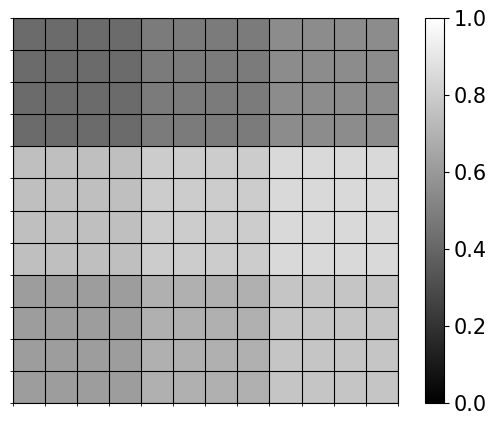

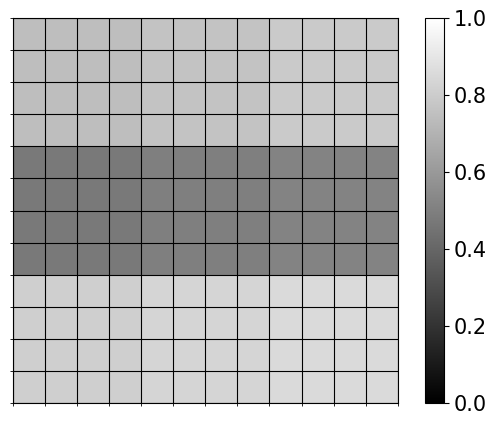

In [13]:
FA = dkifu.fa
MK = dkifu.mk()
FAgt_unc = FA
MKgt_unc = MK

plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

Below, I am showing the ground truth phantom for spatially correlated noise 

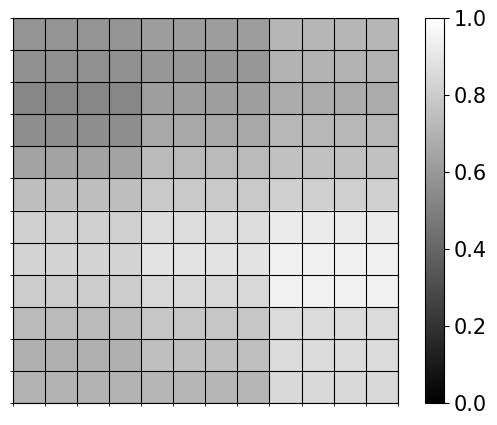

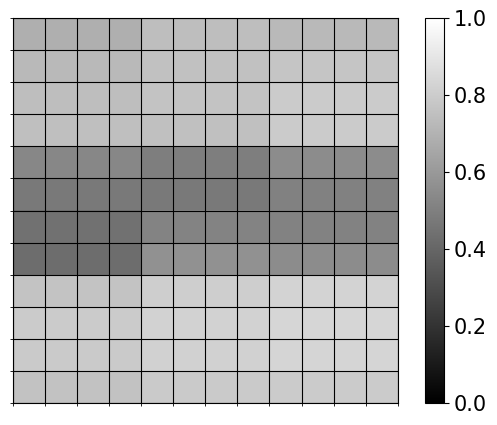

In [14]:
FA = dkifc.fa
MK = dkifc.mk()
FAgt_cor = FA
MKgt_cor = MK

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

compute reference directions

In [15]:
csamodel = CsaOdfModel(gtab_sel, 6)

In [17]:
#uncorrelated reference
DWI_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWI_4D[:, :, 0, :] = DWI[:, :, sel_ind]

csapeaks_ref = peaks_from_model(model=csamodel,
                                data=DWI_4D,
                                sphere=sphere,
                                relative_peak_threshold=.2,
                                min_separation_angle=25,
                                return_odf=False,
                                normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks_ref.peak_dirs,
#                                   csapeaks_ref.peak_values*0.5)
#csa_odfs_actor.display(z=0)
#
#scene.add(csa_odfs_actor)
#
#window.show(scene)

In [18]:
#correlated reference
DWI_4Dc = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWI_4Dc[:, :, 0, :] = DWIc[:, :, sel_ind]

csapeaks_cor_ref = peaks_from_model(model=csamodel,
                                    data=DWI_4Dc,
                                    sphere=sphere,
                                    relative_peak_threshold=.2,
                                    min_separation_angle=25,
                                    return_odf=False,
                                    normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks_cor_ref.peak_dirs,
#                                   csapeaks_cor_ref.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

# Add noise

In [19]:
sig2 = (1/snr) ** 2  

if gaussian:
    DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
else:
    DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')

if corrupt == 1:
    DWInc = smooth(DWIn, gauss_std)
if corrupt == 2:
    DWInc = zero_fill(DWIn.copy(), zf)

In [20]:
dkifu = dkim.fit(DWIn)
dkifc = dkim.fit(DWInc)

Let's plot the MK and FA reconstruction for noise corrupted data (<ins>Spatially uncorrelated noise</ins>)

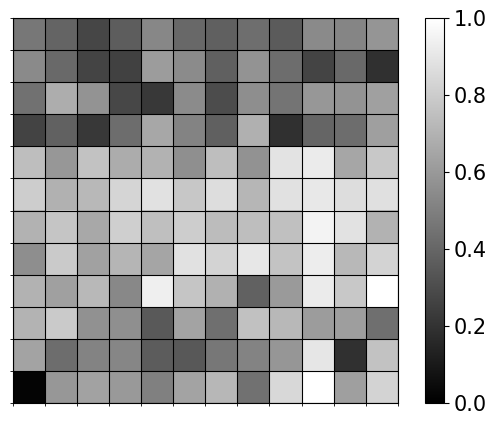

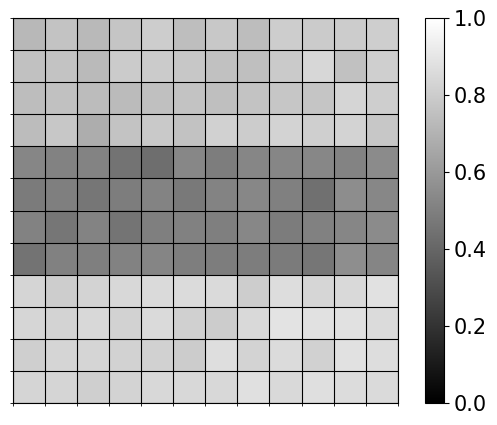

In [21]:
FA = dkifu.fa
MK = dkifu.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

Let's plot the MK and FA reconstruction for noise corrupted data (<ins>Spatially correlated noise</ins>)

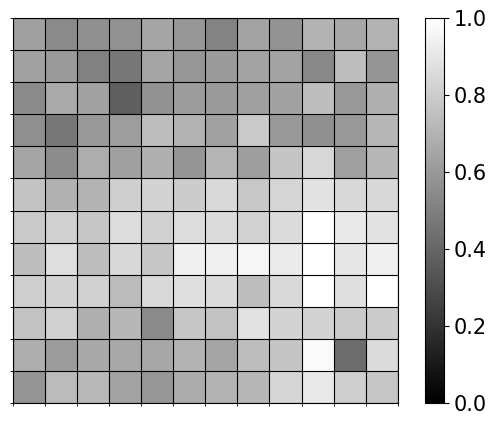

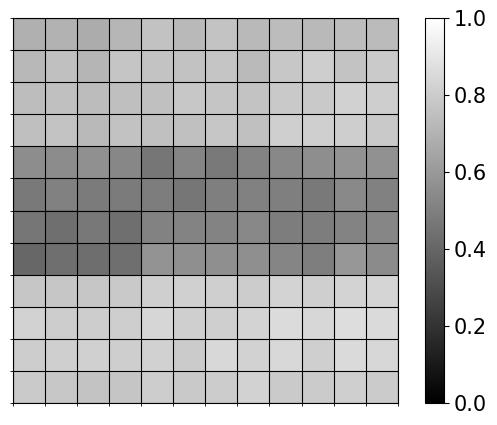

In [22]:
FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

In [23]:
# Let's plot the errors for fiber directions
#uncorrelated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWIn[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

In [24]:
def calculate_angular_error_map(csapeaks, csapeaks_ref):
    data_shape = csapeaks.peak_values.shape
    ang_err_map = np.zeros(data_shape[:2])
    for nx in range(data_shape[0]):
        for ny in range(data_shape[1]):
            indx = np.argmax(csapeaks.peak_values[nx, ny, 0])
            dir_sel = csapeaks.peak_dirs[nx, ny, 0, indx, :]
            dir_ref = csapeaks_ref.peak_dirs[nx, ny, 0, :, :]
            ddt = np.abs(np.matmul(dir_ref, dir_sel.T))
            indx_ref = np.argmax(ddt)
            ang_err_map[nx, ny] = np.arccos(np.clip(np.abs(ddt[indx_ref]), 0, 1))/np.pi*180
    return ang_err_map

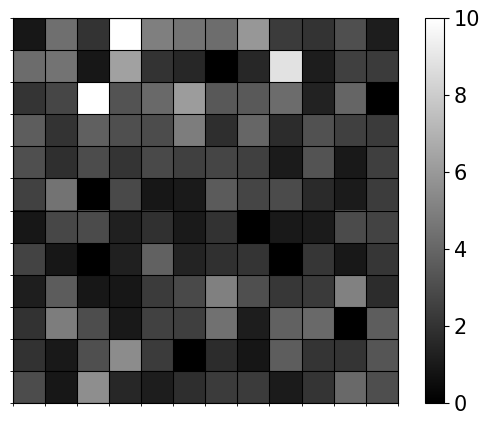

In [25]:
ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

In [28]:
# Let's plot the errors for fiber directions
#correlated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWInc[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

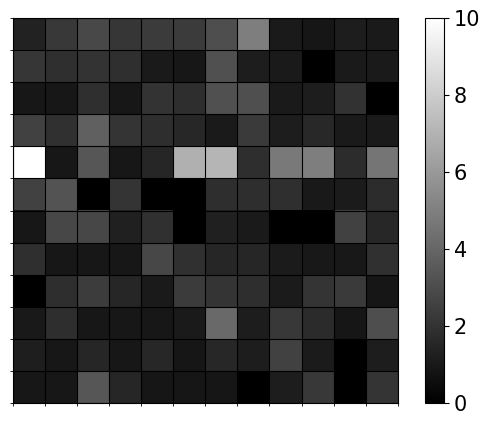

In [29]:
ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_cor_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

# MPPCA Denoising

In [30]:
# Let's convert phantoms to a 2D matrix
n = DWIn.shape[-1]
m = DWIn.shape[0]*DWIn.shape[1]
y = n*1.0/m
X = DWIn.reshape(m, n)
M = np.mean(X, axis=0)
X = X - M
Xc = DWInc.reshape(m, n)
Mc = np.mean(Xc, axis=0)
Xc = Xc - Mc

In [31]:
# MP-PCA denoising
Xd, ncomps = _pca_matrix(X)
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

Xdc, ncomps = _pca_matrix(Xc)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

102
63


In [32]:
dkifu = dkim.fit(DWId)
dkifc = dkim.fit(DWIdc)

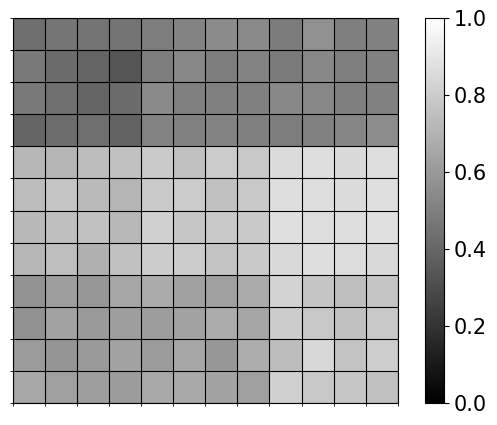

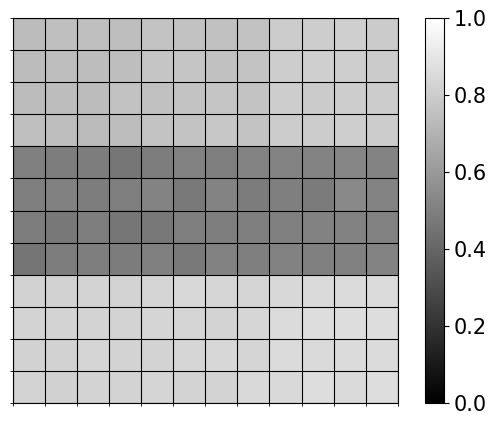

In [33]:
# Uncorrelated

FA = dkifu.fa
MK = dkifu.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

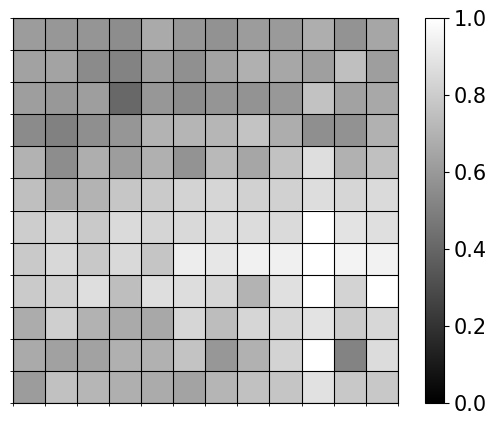

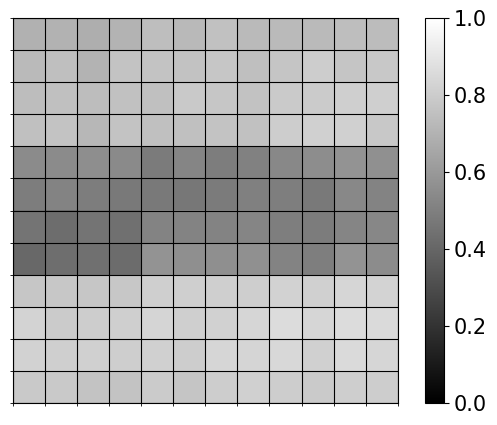

In [34]:
# Noise correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

MP-PCA successfully suppresses noise when it is spatially uncorrelated but its performance is limited on spatially correlated noise.

Fiber errors

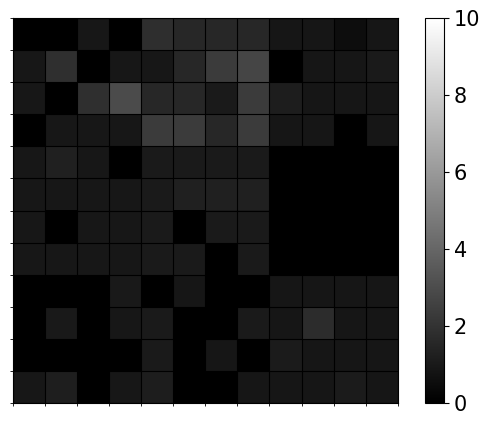

In [35]:
# Let's plot the errors for fiber directions
#uncorrelated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWId[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

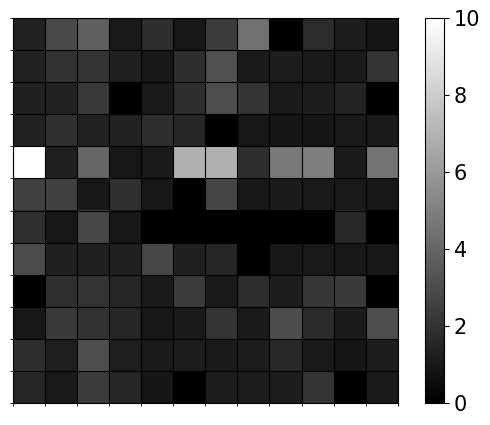

In [36]:
# Let's plot the errors for fiber directions
#uncorrelated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWIdc[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_cor_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

# MPPCA-slow Denoising

In [37]:
# MP-PCA slow denoising
t = time()
Xd, ncomps = _pca_matrix(X, mppca_slow=True)
tf = time() - t
print("Time taken for MPPCA ", tf)
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

t = time()
Xdc, ncomps = _pca_matrix(Xc, mppca_slow=True)
tf = time() - t
print("Time taken for MPPCA ", tf)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

Time taken for MPPCA  0.23647212982177734
100
Time taken for MPPCA  0.40904664993286133
70


In [38]:
dkifu = dkim.fit(DWId)
dkifc = dkim.fit(DWIdc)

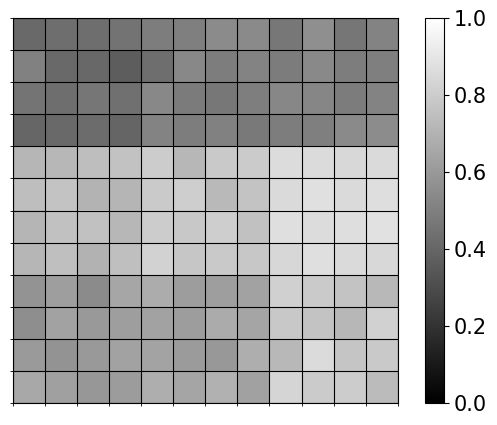

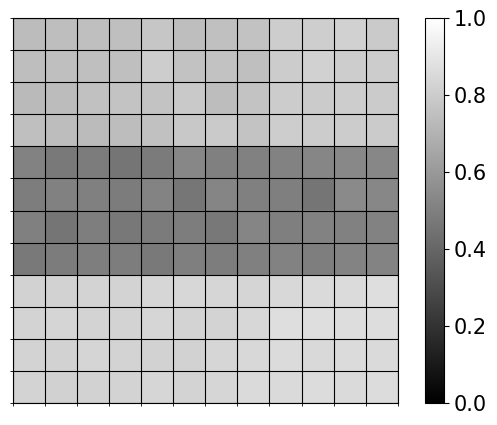

In [39]:
# Uncorrelated

FA = dkifu.fa
MK = dkifu.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

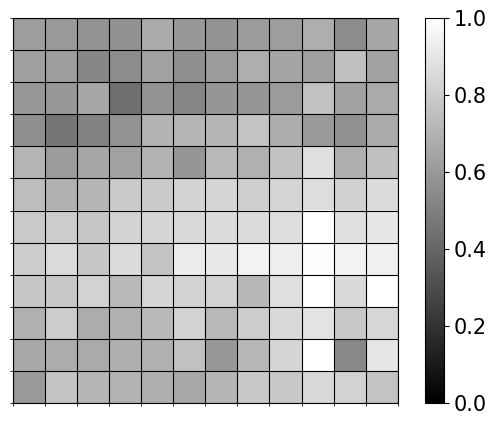

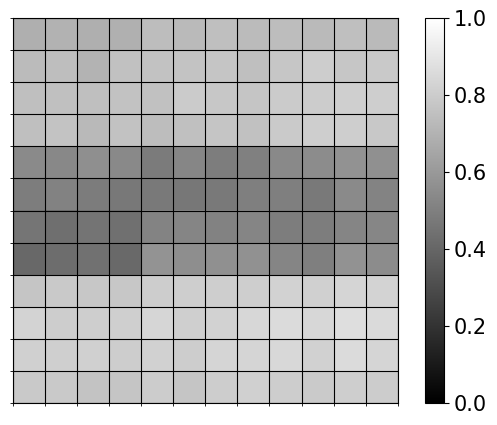

In [40]:
# Noise correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

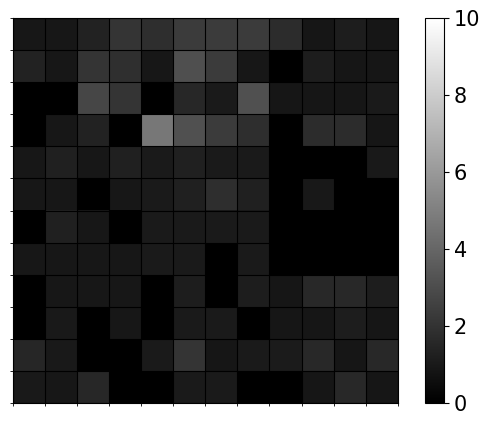

In [41]:
# Let's plot the errors for fiber directions
#uncorrelated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWId[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

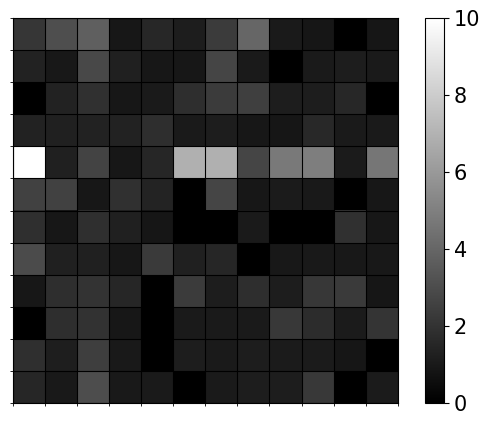

In [42]:
# Let's plot the errors for fiber directions
#uncorrelated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWIdc[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_cor_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

# GPCA Denoising

In [43]:
# General PCA denoising
varp1 = np.mean(np.var(DWIn[..., gtab.b0s_mask], axis=-1, ddof=1))
varp2 = np.mean(np.var(DWInc[..., gtab.b0s_mask], axis=-1, ddof=1))

Xd, ncomps = _pca_matrix(X, sig2=varp1)
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

Xdc, ncomps = _pca_matrix(Xc, sig2=varp2)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

102
102


In [44]:
dkifu = dkim.fit(DWId)
dkifc = dkim.fit(DWIdc)

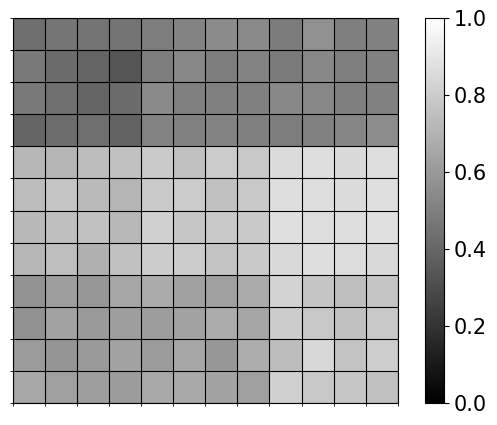

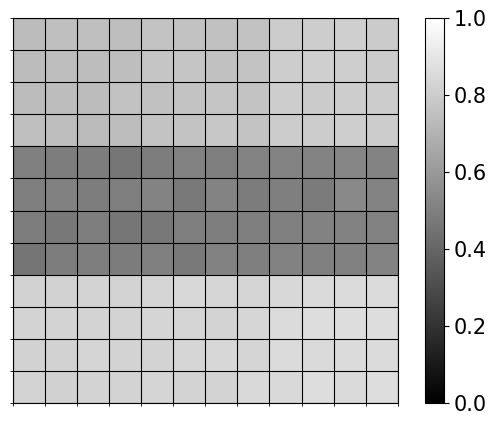

In [45]:
# Uncorrelated

FA = dkifu.fa
MK = dkifu.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

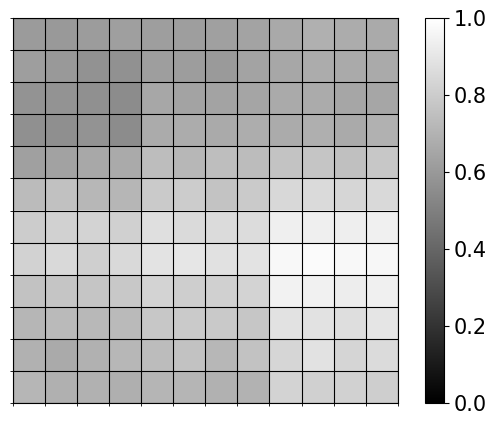

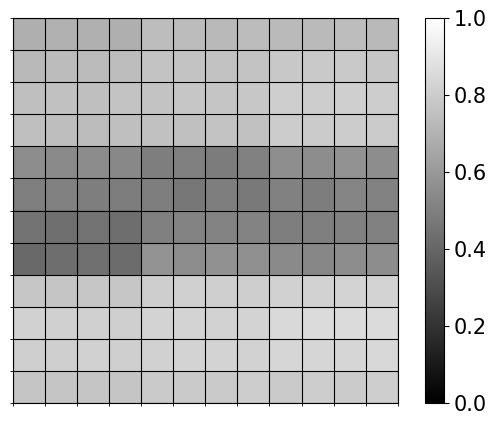

In [46]:
# Correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

GPCA has an optimal performance for both spatially uncorrelated and correlated noise. For both cases, it correclty detected the 102 ground truth noise components of the phantoms.

Fiber direction error maps

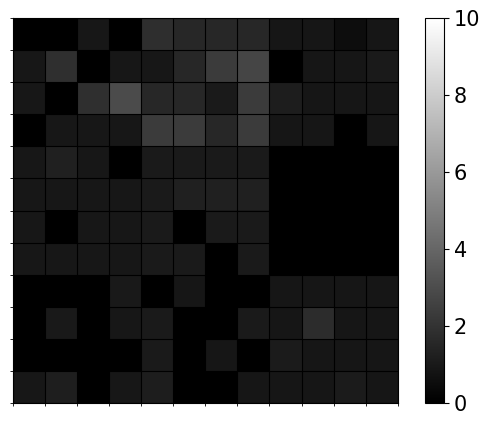

In [47]:
# Let's plot the errors for fiber directions
#uncorrelated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWId[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

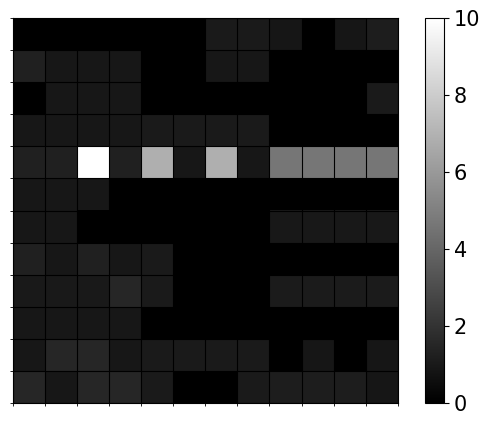

In [48]:
# Let's plot the errors for fiber directions
#uncorrelated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWIdc[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_cor_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

In [49]:
np.max(ang_err_map)

10.838591920703546

# TPCA Denoising

In [50]:
Xd, ncomps = _pca_matrix(X, sig2=varp1, tau_factor=1+np.sqrt(n / m))
Xd = Xd + M
DWId = Xd.reshape(DWIn.shape)
print(ncomps)

Xdc, ncomps = _pca_matrix(Xc, sig2=varp2, tau_factor=1+np.sqrt(n / m))
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

102
100


In [51]:
dkifu = dkim.fit(DWId)
dkifc = dkim.fit(DWIdc)

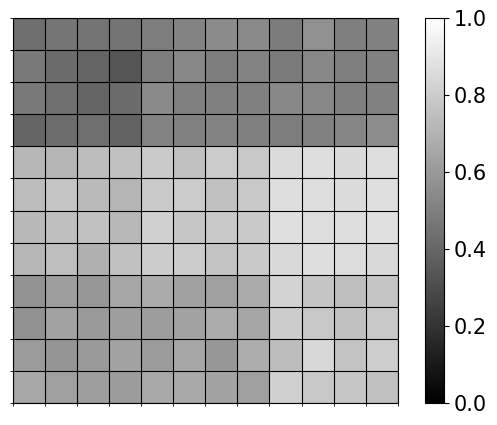

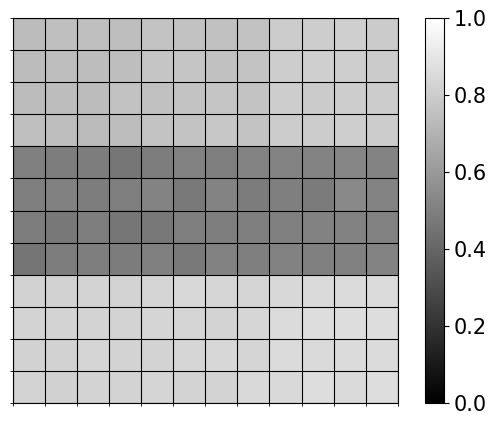

In [52]:
# Uncorrelated

FA = dkifu.fa
MK = dkifu.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

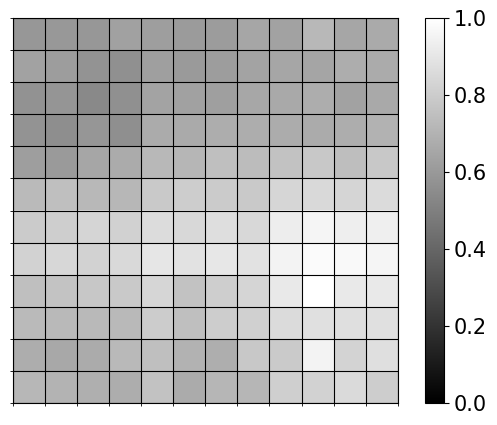

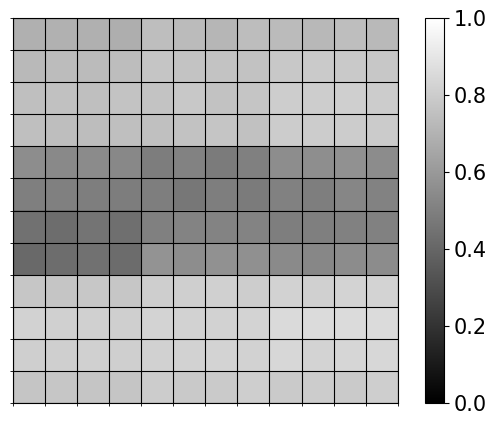

In [53]:
# Correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

TPCA denoising also provides robust denoising for both spatially uncorrelated and correlated phantoms. However, it perserved 2 more signal components than expected.

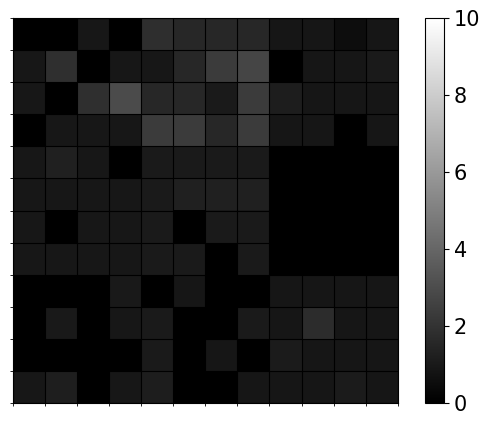

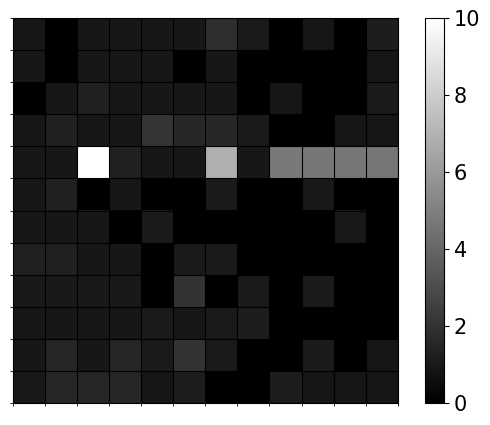

In [54]:
# Let's plot the errors for fiber directions
#uncorrelated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWId[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)




# Let's plot the errors for fiber directions
#correlated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWIdc[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_cor_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

# Quantification of SNR gain in kurtosis metrics

In [55]:
# Ground truth for uncorrelated noise
DWI = fib3_phantom_9comps(gtab, N=N)

# Ground truth for correlated noise
if corrupt == 1:
    DWIc = smooth(DWI.copy(), gauss_std)
else:
    DWIc = zero_fill(DWI.copy(), zf)

m = DWI.shape[0] * DWI.shape[1]

In [56]:
dkifc = dkim.fit(DWIc)

In [57]:
FAgt = dkifc.fa
MDgt = dkifc.md
ADgt = dkifc.ad
RDgt = dkifc.rd
MKgt = dkifc.mk()
AKgt = dkifc.ak()
RKgt = dkifc.rk()

In [58]:
FAgt = FAgt.reshape(m)
MDgt = MDgt.reshape(m)
ADgt = ADgt.reshape(m)
RDgt = RDgt.reshape(m)
MKgt = MKgt.reshape(m)
AKgt = AKgt.reshape(m)
RKgt = RKgt.reshape(m)

In [59]:
# spatially correlated noise

nrep = 100

FAraw_e = np.array([])
MDraw_e = np.array([])
ADraw_e = np.array([])
RDraw_e = np.array([])
MKraw_e = np.array([])
AKraw_e = np.array([])
RKraw_e = np.array([])
AGraw_e = np.array([])

FAmpca_e = np.array([])
MDmpca_e = np.array([])
ADmpca_e = np.array([])
RDmpca_e = np.array([])
MKmpca_e = np.array([])
AKmpca_e = np.array([])
RKmpca_e = np.array([])
AGmpca_e = np.array([])

#FAmpca_s_e = np.array([])
#MDmpca_s_e = np.array([])
#ADmpca_s_e = np.array([])
#RDmpca_s_e = np.array([])
#MKmpca_s_e = np.array([])
#AKmpca_s_e = np.array([])
#RKmpca_s_e = np.array([])
#AGmpca_s_e = np.array([])

FAgpca_e = np.array([])
MDgpca_e = np.array([])
ADgpca_e = np.array([])
RDgpca_e = np.array([])
MKgpca_e = np.array([])
AKgpca_e = np.array([])
RKgpca_e = np.array([])
AGgpca_e = np.array([])

FAtpca_e = np.array([])
MDtpca_e = np.array([])
ADtpca_e = np.array([])
RDtpca_e = np.array([])
MKtpca_e = np.array([])
AKtpca_e = np.array([])
RKtpca_e = np.array([])
AGtpca_e = np.array([])

over_fac = 1

for rep in range(nrep):
    if gaussian:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
    else:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')
    
    if corrupt == 1:
        DWIn = smooth(DWIn.copy(), gauss_std)
    else:
        DWIn = zero_fill(DWIn.copy(), zf)
    var_all = (over_fac**2) * np.mean(np.var(DWIn[..., gtab.b0s_mask], axis=-1, ddof=1))

    X = DWIn.reshape(m, n)
    M = np.mean(X, axis=0)
    
    # Raw
    dki_raw = dkim.fit(X)
    FAraw_e = np.append(FAraw_e, dki_raw.fa - FAgt)
    MDraw_e = np.append(MDraw_e, dki_raw.md - MDgt)
    ADraw_e = np.append(ADraw_e, dki_raw.ad - ADgt)
    RDraw_e = np.append(RDraw_e, dki_raw.rd - RDgt)
    MKraw_e = np.append(MKraw_e, dki_raw.mk() - MKgt)
    AKraw_e = np.append(AKraw_e, dki_raw.ak() - AKgt)
    RKraw_e = np.append(RKraw_e, dki_raw.rk() - RKgt)
    
    DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
    DWIn_4D[:, :, 0, :] = DWIn[:, :, sel_ind]
    csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

    ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)
    AGraw_e = np.append(AGraw_e,  ang_err_map.reshape(m))
    
    X = X - M
    
    # MPPCA
    Xmpca, ncomps = _pca_matrix(X)
    Xmpca = Xmpca + M
    dki_mpca = dkim.fit(Xmpca)
    FAmpca_e = np.append(FAmpca_e, dki_mpca.fa - FAgt)
    MDmpca_e = np.append(MDmpca_e, dki_mpca.md - MDgt)
    ADmpca_e = np.append(ADmpca_e, dki_mpca.ad - ADgt)
    RDmpca_e = np.append(RDmpca_e, dki_mpca.rd - RDgt)
    MKmpca_e = np.append(MKmpca_e, dki_mpca.mk() - MKgt)
    AKmpca_e = np.append(AKmpca_e, dki_mpca.ak() - AKgt)
    RKmpca_e = np.append(RKmpca_e, dki_mpca.rk() - RKgt)
    
    DWIn = Xmpca.reshape((N, N, len(gtab.bvals)))
    DWIn_4D[:, :, 0, :] = DWIn[:, :, sel_ind]
    csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

    ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)
    AGmpca_e = np.append(AGmpca_e,  ang_err_map.reshape(m))
    
    # MPPCA-slow
    #Xmpca, ncomps = _pca_matrix(X, mppca_slow=True)
    #Xmpca = Xmpca + M
    #dki_mpca = dkim.fit(Xmpca)
    #FAmpca_s_e = np.append(FAmpca_s_e, dki_mpca.fa - FAgt)
    #MDmpca_s_e = np.append(MDmpca_s_e, dki_mpca.md - MDgt)
    #ADmpca_s_e = np.append(ADmpca_s_e, dki_mpca.ad - ADgt)
    #RDmpca_s_e = np.append(RDmpca_s_e, dki_mpca.rd - RDgt)
    #MKmpca_s_e = np.append(MKmpca_s_e, dki_mpca.mk() - MKgt)
    #AKmpca_s_e = np.append(AKmpca_s_e, dki_mpca.ak() - AKgt)
    #RKmpca_s_e = np.append(RKmpca_s_e, dki_mpca.rk() - RKgt)
    
    #DWIn = Xmpca.reshape((N, N, len(gtab.bvals)))
    #DWIn_4D[:, :, 0, :] = DWIn[:, :, sel_ind]
    #csapeaks = peaks_from_model(model=csamodel,
    #                        data=DWIn_4D,
    #                        sphere=sphere,
    #                        relative_peak_threshold=.5,
    #                        min_separation_angle=25,
    #                        return_odf=False,
    #                        normalize_peaks=True)

    #ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)
    #AGmpca_s_e = np.append(AGmpca_s_e,  ang_err_map.reshape(m))
    
    # GPCA
    Xgpca, ncomps = _pca_matrix(X, sig2=var_all)
    print(ncomps)
    Xgpca = Xgpca + M
    dki_gpca = dkim.fit(Xgpca)
    FAgpca_e = np.append(FAgpca_e, dki_gpca.fa - FAgt)
    MDgpca_e = np.append(MDgpca_e, dki_gpca.md - MDgt)
    ADgpca_e = np.append(ADgpca_e, dki_gpca.ad - ADgt)
    RDgpca_e = np.append(RDgpca_e, dki_gpca.rd - RDgt)
    MKgpca_e = np.append(MKgpca_e, dki_gpca.mk() - MKgt)
    AKgpca_e = np.append(AKgpca_e, dki_gpca.ak() - AKgt)
    RKgpca_e = np.append(RKgpca_e, dki_gpca.rk() - RKgt)
    
    DWIn = Xgpca.reshape((N, N, len(gtab.bvals)))
    DWIn_4D[:, :, 0, :] = DWIn[:, :, sel_ind]
    csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

    ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)
    AGgpca_e = np.append(AGgpca_e,  ang_err_map.reshape(m))
    
    # TPCA
    Xtpca, ncomps = _pca_matrix(X, sig2=var_all, tau_factor=1+np.sqrt(n / m))
    print(ncomps)
    Xtpca = Xtpca + M
    dki_tpca = dkim.fit(Xtpca)
    FAtpca_e = np.append(FAtpca_e, dki_tpca.fa - FAgt)
    MDtpca_e = np.append(MDtpca_e, dki_tpca.md - MDgt)
    ADtpca_e = np.append(ADtpca_e, dki_tpca.ad - ADgt)
    RDtpca_e = np.append(RDtpca_e, dki_tpca.rd - RDgt)
    MKtpca_e = np.append(MKtpca_e, dki_tpca.mk() - MKgt)
    AKtpca_e = np.append(AKtpca_e, dki_tpca.ak() - AKgt)
    RKtpca_e = np.append(RKtpca_e, dki_tpca.rk() - RKgt)
    
    DWIn = Xtpca.reshape((N, N, len(gtab.bvals)))
    DWIn_4D[:, :, 0, :] = DWIn[:, :, sel_ind]
    csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

    ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)
    AGtpca_e = np.append(AGtpca_e,  ang_err_map.reshape(m))
    
    print(rep)


102
101
0
102
102
1
102
101
2
102
102
3
102
101
4
102
102
5
102
100
6
102
100
7
102
101
8
102
102
9
102
101
10
102
102
11
102
101
12
102
101
13
102
101
14
102
101
15
102
100
16
102
101
17
102
101
18
102
101
19
102
100
20
102
102
21
102
100
22
102
101
23
102
99
24
102
100
25
102
101
26
102
100
27
102
101
28
102
101
29
102
100
30
102
99
31
102
100
32
102
100
33
102
102
34
102
100
35
102
100
36
102
101
37
102
100
38
102
101
39
102
101
40
102
101
41
102
100
42
102
101
43
102
101
44
102
101
45
102
101
46
102
100
47
102
101
48
102
101
49
102
100
50
102
101
51
102
101
52
102
100
53
102
101
54
102
101
55
102
100
56
102
99
57
102
101
58
102
101
59
102
100
60
102
101
61
102
101
62
102
101
63
102
101
64
102
100
65
102
101
66
102
101
67
102
102
68
102
101
69
102
99
70
102
99
71
102
101
72
102
101
73
102
101
74
102
101
75
102
100
76
102
101
77
102
101
78
102
100
79
102
100
80
102
101
81
102
100
82
102
101
83
102
101
84
102
100
85
102
101
86
102
100
87
102
101
88
102
101
89
102
101
90
102
99
91
102


In [64]:
AGraw_e.shape

(14400,)

100.0

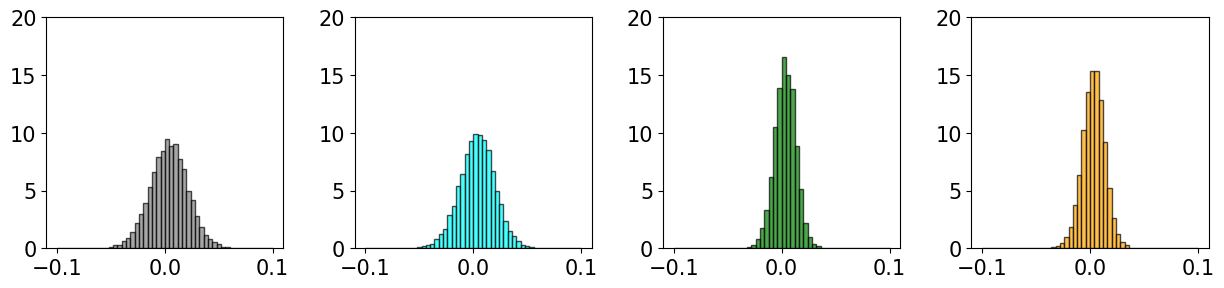

In [65]:
fig1, ax = plt.subplots(1, 4, figsize=(15, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.3)

counts, ed = np.histogram(FAraw_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[0].bar(ed[:-1]+np.diff(ed[:2])/2, counts/2.5, width = (0.2)/50, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAmpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[1].bar(ed[:-1]+np.diff(ed[:2])/2, counts/2.5, width = (0.2)/50, color='cyan', alpha=0.7, edgecolor='black', label='measured dist.')

#counts, ed = np.histogram(FAmpca_s_e, bins=50, range=(-0.1, 0.1), density=True)
#cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts/2.5, width = (0.2)/50, color='magenta', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAgpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts/2.5, width = (0.2)/50, color='green', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAtpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[3].bar(ed[:-1]+np.diff(ed[:2])/2, counts/2.5, width = (0.2)/50, color='orange', alpha=0.7, edgecolor='black', label='measured dist.')

for ai in range(4):
    ax.flat[ai].set_ylim([0, 20])
np.sum(counts/2.5)

99.99999999999997

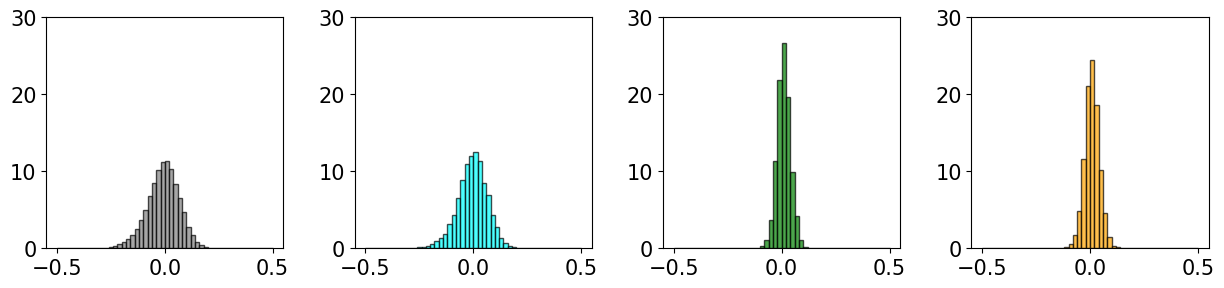

In [66]:
fig1, ax = plt.subplots(1, 4, figsize=(15, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.3)

counts, ed = np.histogram(MKraw_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[0].bar(ed[:-1]+np.diff(ed[:2])/2, counts*2, width = 1/50, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKmpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[1].bar(ed[:-1]+np.diff(ed[:2])/2, counts*2, width = 1/50, color='cyan', alpha=0.7, edgecolor='black', label='measured dist.')

#counts, ed = np.histogram(MKmpca_s_e, bins=50, range=(-0.5, 0.5), density=True)
#cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts*2, width = 1/50, color='magenta', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKgpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts*2, width = 1/50, color='green', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKtpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[3].bar(ed[:-1]+np.diff(ed[:2])/2, counts*2, width = 1/50, color='orange', alpha=0.7, edgecolor='black', label='measured dist.')

for ai in range(4):
    ax.flat[ai].set_ylim([0, 30])
    
np.sum(counts*2)

100.00000000000001

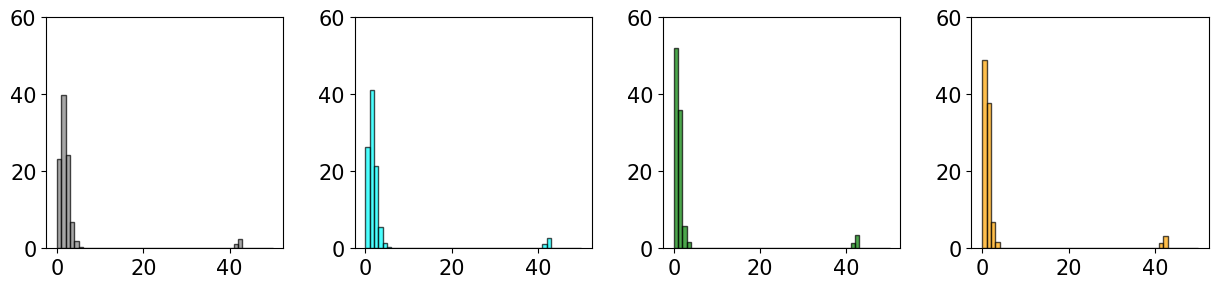

In [67]:
fig1, ax = plt.subplots(1, 4, figsize=(15, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.3)

counts, ed = np.histogram(AGraw_e, bins=50, range=(0, 50), density=True)
cax0 = ax.flat[0].bar(ed[:-1]+np.diff(ed[:2])/2, counts*100, width = 1, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(AGmpca_e, bins=50, range=(0, 50), density=True)
cax0 = ax.flat[1].bar(ed[:-1]+np.diff(ed[:2])/2, counts*100, width = 1, color='cyan', alpha=0.7, edgecolor='black', label='measured dist.')

#counts, ed = np.histogram(AGmpca_s_e, bins=50, range=(0, 50), density=True)
#cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts*100, width = 1, color='magenta', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(AGgpca_e, bins=50, range=(0, 50), density=True)
cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts*100, width = 1, color='green', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(AGtpca_e, bins=50, range=(0, 50), density=True)
cax0 = ax.flat[3].bar(ed[:-1]+np.diff(ed[:2])/2, counts*100, width = 1, color='orange', alpha=0.7, edgecolor='black', label='measured dist.')

for ai in range(4):
    ax.flat[ai].set_ylim([0, 60])

np.sum(counts*100)

In [68]:
RMSEfa_raw = np.sqrt(np.mean(FAraw_e ** 2))
RMSEmd_raw = np.sqrt(np.mean(MDraw_e ** 2)) * 1000
RMSErd_raw = np.sqrt(np.mean(RDraw_e ** 2)) * 1000
RMSEad_raw = np.sqrt(np.mean(ADraw_e ** 2)) * 1000
RMSEmk_raw = np.sqrt(np.mean(MKraw_e ** 2))
RMSErk_raw = np.sqrt(np.mean(RKraw_e ** 2))
RMSEak_raw = np.sqrt(np.mean(AKraw_e ** 2))

RMSEfa_mpca = np.sqrt(np.mean(FAmpca_e ** 2))
RMSEmd_mpca = np.sqrt(np.mean(MDmpca_e ** 2)) * 1000
RMSErd_mpca = np.sqrt(np.mean(RDmpca_e ** 2)) * 1000
RMSEad_mpca = np.sqrt(np.mean(ADmpca_e ** 2)) * 1000
RMSEmk_mpca = np.sqrt(np.mean(MKmpca_e ** 2))
RMSErk_mpca = np.sqrt(np.mean(RKmpca_e ** 2))
RMSEak_mpca = np.sqrt(np.mean(AKmpca_e ** 2))

#RMSEfa_mpca_s = np.sqrt(np.mean(FAmpca_s_e ** 2))
#RMSEmd_mpca_s = np.sqrt(np.mean(MDmpca_s_e ** 2)) * 1000
#RMSErd_mpca_s = np.sqrt(np.mean(RDmpca_s_e ** 2)) * 1000
#RMSEad_mpca_s = np.sqrt(np.mean(ADmpca_s_e ** 2)) * 1000
#RMSEmk_mpca_s = np.sqrt(np.mean(MKmpca_s_e ** 2))
#RMSErk_mpca_s = np.sqrt(np.mean(RKmpca_s_e ** 2))
#RMSEak_mpca_s = np.sqrt(np.mean(AKmpca_s_e ** 2))

RMSEfa_gpca = np.sqrt(np.mean(FAgpca_e ** 2))
RMSEmd_gpca = np.sqrt(np.mean(MDgpca_e ** 2)) * 1000
RMSErd_gpca = np.sqrt(np.mean(RDgpca_e ** 2)) * 1000
RMSEad_gpca = np.sqrt(np.mean(ADgpca_e ** 2)) * 1000
RMSEmk_gpca = np.sqrt(np.mean(MKgpca_e ** 2))
RMSErk_gpca = np.sqrt(np.mean(RKgpca_e ** 2))
RMSEak_gpca = np.sqrt(np.mean(AKgpca_e ** 2))
    
RMSEfa_tpca = np.sqrt(np.mean(FAtpca_e ** 2))
RMSEmd_tpca = np.sqrt(np.mean(MDtpca_e ** 2)) * 1000
RMSErd_tpca = np.sqrt(np.mean(RDtpca_e ** 2)) * 1000
RMSEad_tpca = np.sqrt(np.mean(ADtpca_e ** 2)) * 1000
RMSEmk_tpca = np.sqrt(np.mean(MKtpca_e ** 2))
RMSErk_tpca = np.sqrt(np.mean(RKtpca_e ** 2))
RMSEak_tpca = np.sqrt(np.mean(AKtpca_e ** 2))

In [69]:
print('Raw')
print(RMSEfa_raw)
print(RMSEmd_raw)
print(RMSErd_raw)
print(RMSEad_raw)
print(RMSEmk_raw)
print(RMSErk_raw)
print(RMSEak_raw)
print(' ')
print('MPPCA')
print(RMSEfa_mpca)
print(RMSEmd_mpca)
print(RMSErd_mpca)
print(RMSEad_mpca)
print(RMSEmk_mpca)
print(RMSErk_mpca)
print(RMSEak_mpca)
print(' ')
#print('MPPCA-slow')
#print(RMSEfa_mpca_s)
#print(RMSEmd_mpca_s)
#print(RMSErd_mpca_s)
#print(RMSEad_mpca_s)
#print(RMSEmk_mpca_s)
#print(RMSErk_mpca_s)
#print(RMSEak_mpca_s)
#print(' ')
print('GPCA')
print(RMSEfa_gpca)
print(RMSEmd_gpca)
print(RMSErd_gpca)
print(RMSEad_gpca)
print(RMSEmk_gpca)
print(RMSErk_gpca)
print(RMSEak_gpca)
print(' ')
print('TPCA')
print(RMSEfa_tpca)
print(RMSEmd_tpca)
print(RMSErd_tpca)
print(RMSEad_tpca)
print(RMSEmk_tpca)
print(RMSErk_tpca)
print(RMSEak_tpca)

Raw
0.018101457931786906
0.017068173351014244
0.0157069741763048
0.05099457325833196
0.07576736177772207
0.28106877721887047
0.2557998120626491
 
MPPCA
0.016960057860925918
0.01574064726193553
0.014596445948978682
0.04765438995348832
0.06883741125739108
0.25977707847998754
0.24395083917987007
 
GPCA
0.010319323483989293
0.007499280983450846
0.007991306211996018
0.027269484800166333
0.0322516323871294
0.15331394436590404
0.19761865300409695
 
TPCA
0.010865774361696693
0.008333829600935917
0.00860656273039268
0.029167486128828395
0.0353622000464739
0.1640464820263548
0.20692707827793402


# Results for overestimates variance estimates

In [70]:
over_fac = 2

In [71]:
# Ground truth for uncorrelated noise
DWI = fib3_phantom_9comps(gtab, N=N)

# Ground truth for correlated noise
if corrupt == 1:
    DWIc = smooth(DWI.copy(), gauss_std)
else:
    DWIc = zero_fill(DWI.copy(), zf)

m = DWI.shape[0] * DWI.shape[1]

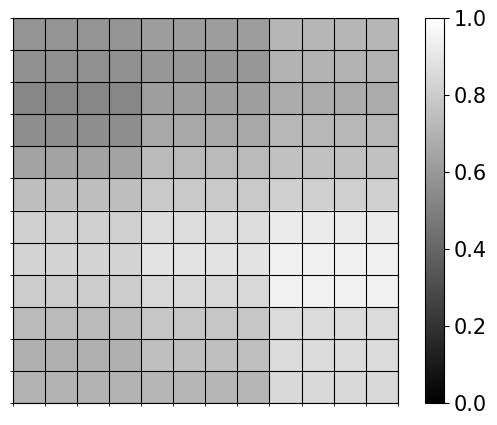

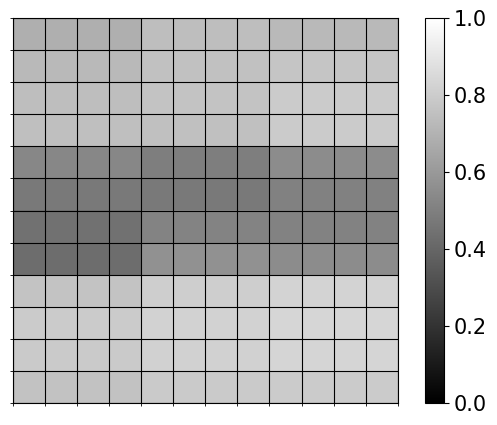

In [72]:
dkifc = dkim.fit(DWIc)

FA = dkifc.fa
MK = dkifc.mk()
FAgt_cor = FA
MKgt_cor = MK

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

In [73]:
sig2 = (1/snr) ** 2  

if gaussian:
    DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
else:
    DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')

if corrupt == 1:
    DWInc = smooth(DWIn, gauss_std)
if corrupt == 2:
    DWInc = zero_fill(DWIn.copy(), zf)

In [74]:
# General PCA denoising
varp2 = (over_fac**2) * np.mean(np.var(DWInc[..., gtab.b0s_mask], axis=-1, ddof=1))

Xdc, ncomps = _pca_matrix(Xc, sig2=varp2)
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

104


In [75]:
dkifc = dkim.fit(DWIdc)

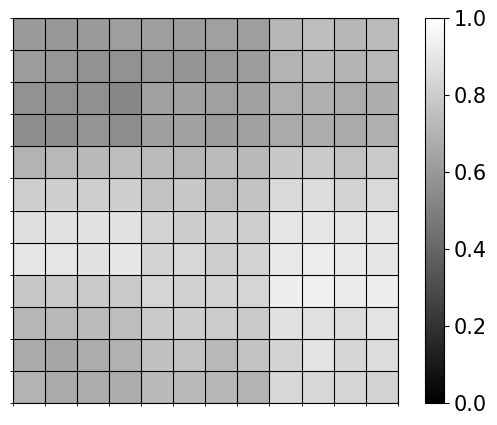

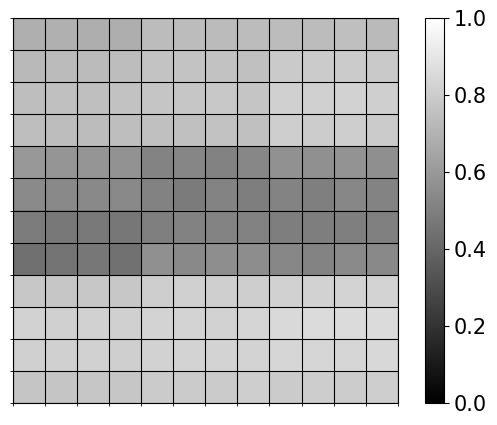

In [76]:
# Correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

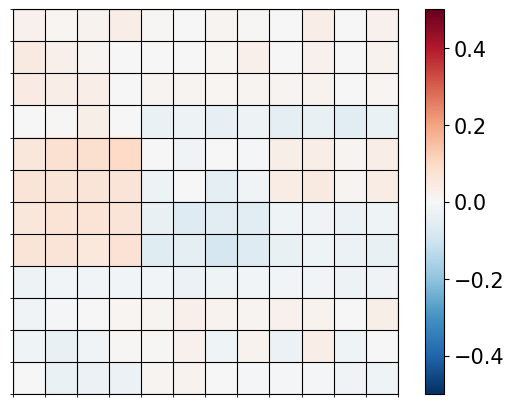

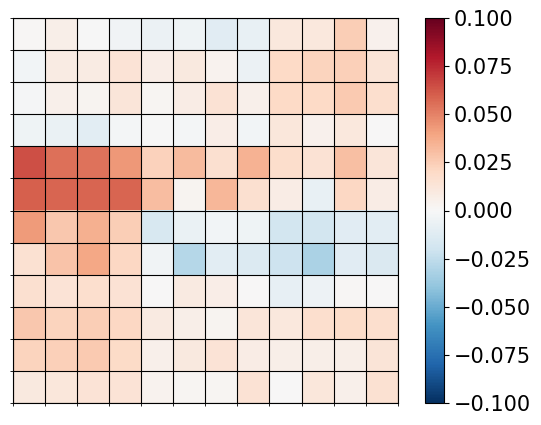

In [77]:
# Correlated

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :]-MKgt_cor[:, :], cmap="RdBu_r", vmin=-.5, vmax=.5)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :]-FAgt_cor[:, :], cmap="RdBu_r", vmin=-0.1, vmax=0.1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

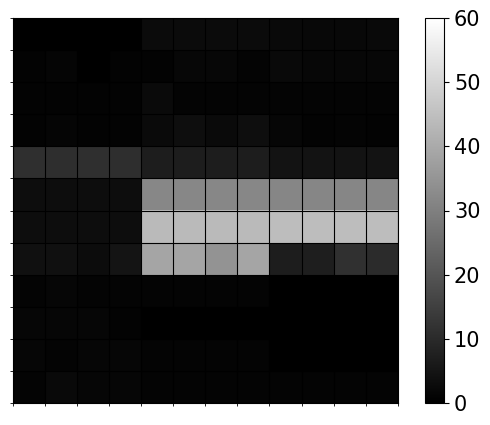

In [78]:
# Let's plot the errors for fiber directions
#correlated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWIdc[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_cor_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=60)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

In [79]:
# TPCA denoising
Xdc, ncomps = _pca_matrix(Xc, sig2=varp2, tau_factor=1+np.sqrt(n / m))
Xdc = Xdc + Mc
DWIdc = Xdc.reshape(DWIn.shape)
print(ncomps)

102


In [80]:
dkifc = dkim.fit(DWIdc)

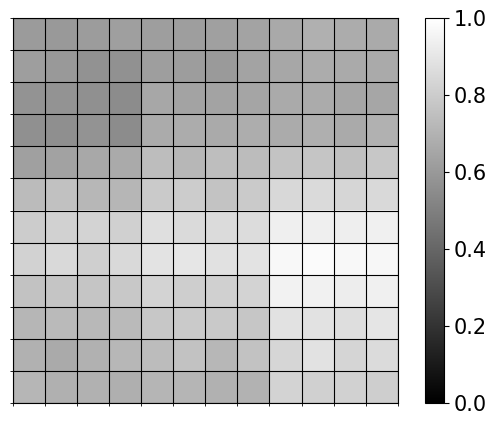

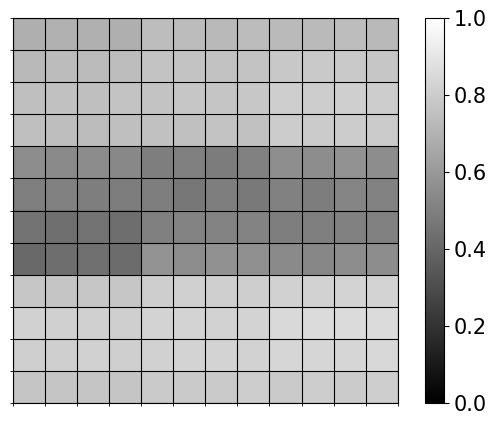

In [81]:
# Correlated

FA = dkifc.fa
MK = dkifc.mk()

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :], cmap="gray", vmin=0, vmax=1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

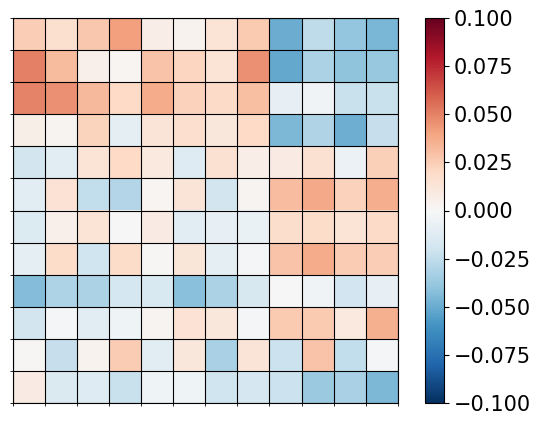

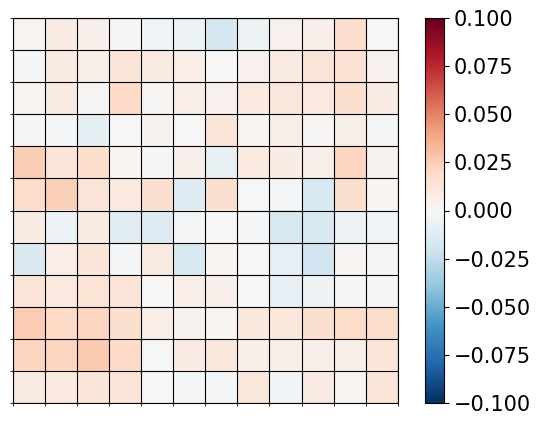

In [82]:
# Correlated

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(MK[:, :]-MKgt_cor[:, :], cmap="RdBu_r", vmin=-.1, vmax=.1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)


fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(FA[:, :]-FAgt_cor[:, :], cmap="RdBu_r", vmin=-0.1, vmax=0.1)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

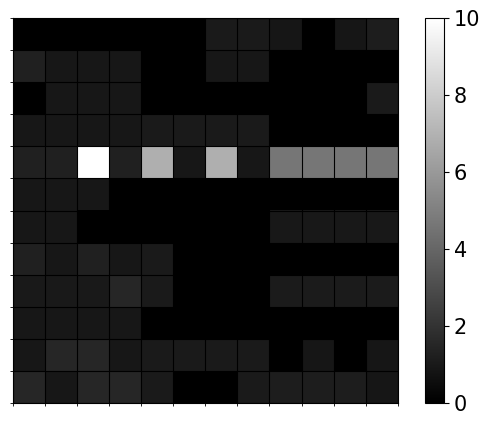

In [83]:
# Let's plot the errors for fiber directions
#correlated noise
DWIn_4D = np.zeros((N, N, 1, len(gtab_sel.bvals)))
DWIn_4D[:, :, 0, :] = DWIdc[:, :, sel_ind]

csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

#from dipy.viz import window, actor
#scene = window.Scene()

#csa_odfs_actor = actor.peak_slicer(csapeaks.peak_dirs, csapeaks.peak_values*0.5)
#csa_odfs_actor.display(z=0)

#scene.add(csa_odfs_actor)

#window.show(scene)

ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_cor_ref)

fig = plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)
ec = plt.imshow(ang_err_map[:, :], cmap="gray", vmin=0, vmax=10)

plt.colorbar(ec)

ax = plt.gca()

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(np.arange(-.5, N, 1), minor=True)
ax.set_yticks(np.arange(-.5, N, 1), minor=True)

ax.grid(which='minor', color='black', linestyle='-', linewidth=0.8)

In [84]:
# spatially correlated noise

nrep = 100

FAgpca_e = np.array([])
MDgpca_e = np.array([])
ADgpca_e = np.array([])
RDgpca_e = np.array([])
MKgpca_e = np.array([])
AKgpca_e = np.array([])
RKgpca_e = np.array([])
AGgpca_e = np.array([])

FAtpca_e = np.array([])
MDtpca_e = np.array([])
ADtpca_e = np.array([])
RDtpca_e = np.array([])
MKtpca_e = np.array([])
AKtpca_e = np.array([])
RKtpca_e = np.array([])
AGtpca_e = np.array([])

for rep in range(nrep):
    if gaussian:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='gaussian')
    else:
        DWIn = add_noise_phantom(DWI.copy(), snr=snr, noise_type='rician')
    
    if corrupt == 1:
        DWIn = smooth(DWIn.copy(), gauss_std)
    else:
        DWIn = zero_fill(DWIn.copy(), zf)
    var_all = (over_fac**2) * np.mean(np.var(DWIn[..., gtab.b0s_mask], axis=-1, ddof=1))

    X = DWIn.reshape(m, n)
    M = np.mean(X, axis=0)
    X = X - M
    
    # GPCA
    Xgpca, ncomps = _pca_matrix(X, sig2=var_all)
    print(ncomps)
    Xgpca = Xgpca + M
    dki_gpca = dkim.fit(Xgpca)
    FAgpca_e = np.append(FAgpca_e, dki_gpca.fa - FAgt)
    MDgpca_e = np.append(MDgpca_e, dki_gpca.md - MDgt)
    ADgpca_e = np.append(ADgpca_e, dki_gpca.ad - ADgt)
    RDgpca_e = np.append(RDgpca_e, dki_gpca.rd - RDgt)
    MKgpca_e = np.append(MKgpca_e, dki_gpca.mk() - MKgt)
    AKgpca_e = np.append(AKgpca_e, dki_gpca.ak() - AKgt)
    RKgpca_e = np.append(RKgpca_e, dki_gpca.rk() - RKgt)
    
    DWIn = Xgpca.reshape((N, N, len(gtab.bvals)))
    DWIn_4D[:, :, 0, :] = DWIn[:, :, sel_ind]
    csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

    ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)
    AGgpca_e = np.append(AGgpca_e,  ang_err_map.reshape(m))
    
    # TPCA
    Xtpca, ncomps = _pca_matrix(X, sig2=var_all, tau_factor=1+np.sqrt(n / m))
    print(ncomps)
    Xtpca = Xtpca + M
    dki_tpca = dkim.fit(Xtpca)
    FAtpca_e = np.append(FAtpca_e, dki_tpca.fa - FAgt)
    MDtpca_e = np.append(MDtpca_e, dki_tpca.md - MDgt)
    ADtpca_e = np.append(ADtpca_e, dki_tpca.ad - ADgt)
    RDtpca_e = np.append(RDtpca_e, dki_tpca.rd - RDgt)
    MKtpca_e = np.append(MKtpca_e, dki_tpca.mk() - MKgt)
    AKtpca_e = np.append(AKtpca_e, dki_tpca.ak() - AKgt)
    RKtpca_e = np.append(RKtpca_e, dki_tpca.rk() - RKgt)
    
    DWIn = Xtpca.reshape((N, N, len(gtab.bvals)))
    DWIn_4D[:, :, 0, :] = DWIn[:, :, sel_ind]
    csapeaks = peaks_from_model(model=csamodel,
                            data=DWIn_4D,
                            sphere=sphere,
                            relative_peak_threshold=.2,
                            min_separation_angle=25,
                            return_odf=False,
                            normalize_peaks=True)

    ang_err_map = calculate_angular_error_map(csapeaks, csapeaks_ref)
    AGtpca_e = np.append(AGtpca_e,  ang_err_map.reshape(m))
    
    print(rep)


104
102
0
105
102
1
105
102
2
105
102
3
105
102
4
105
102
5
105
102
6
104
102
7
105
102
8
105
102
9
105
102
10
105
102
11
104
102
12
105
102
13
105
102
14
105
102
15
105
102
16
105
102
17
105
102
18
105
102
19
104
102
20
105
102
21
104
102
22
105
102
23
105
102
24
105
102
25
105
102
26
105
102
27
105
102
28
105
102
29
105
102
30
105
102
31
105
102
32
105
102
33
105
102
34
104
102
35
105
102
36
105
102
37
104
102
38
105
102
39
105
102
40
105
102
41
105
102
42
105
102
43
104
102
44
105
102
45
105
102
46
105
102
47
104
102
48
105
102
49
105
102
50
104
102
51
105
102
52
105
102
53
105
102
54
104
102
55
104
102
56
105
102
57
105
102
58
105
102
59
105
102
60
105
102
61
105
102
62
104
102
63
105
102
64
105
102
65
105
102
66
105
102
67
105
102
68
105
102
69
105
102
70
105
102
71
104
102
72
105
102
73
105
102
74
105
102
75
105
102
76
105
102
77
105
102
78
105
102
79
105
102
80
105
102
81
105
102
82
105
102
83
104
102
84
105
102
85
105
102
86
105
102
87
105
102
88
105
102
89
105
102
90
104
102
9

In [85]:
over_fac

2

100.0

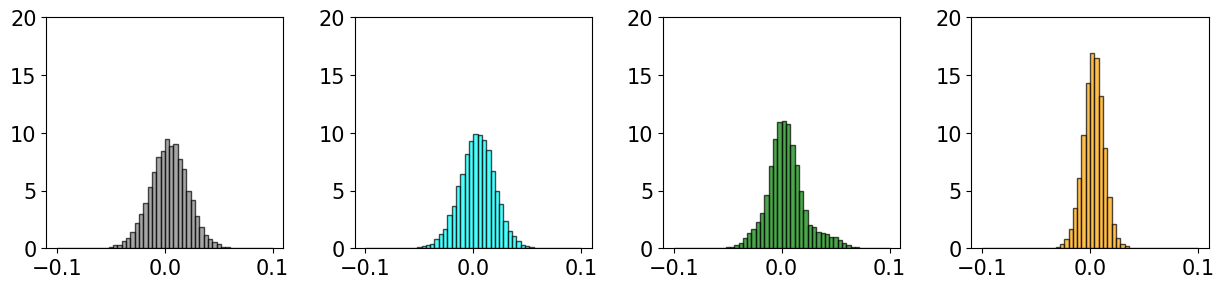

In [86]:
fig1, ax = plt.subplots(1, 4, figsize=(15, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.3)

counts, ed = np.histogram(FAraw_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[0].bar(ed[:-1]+np.diff(ed[:2])/2, counts/2.5, width = (0.2)/50, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAmpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[1].bar(ed[:-1]+np.diff(ed[:2])/2, counts/2.5, width = (0.2)/50, color='cyan', alpha=0.7, edgecolor='black', label='measured dist.')

#counts, ed = np.histogram(FAmpca_s_e, bins=50, range=(-0.1, 0.1), density=True)
#cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts/2.5, width = (0.2)/50, color='magenta', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAgpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts/2.5, width = (0.2)/50, color='green', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(FAtpca_e, bins=50, range=(-0.1, 0.1), density=True)
cax0 = ax.flat[3].bar(ed[:-1]+np.diff(ed[:2])/2, counts/2.5, width = (0.2)/50, color='orange', alpha=0.7, edgecolor='black', label='measured dist.')

for ai in range(4):
    ax.flat[ai].set_ylim([0, 20])
np.sum(counts/2.5)

99.99999999999996

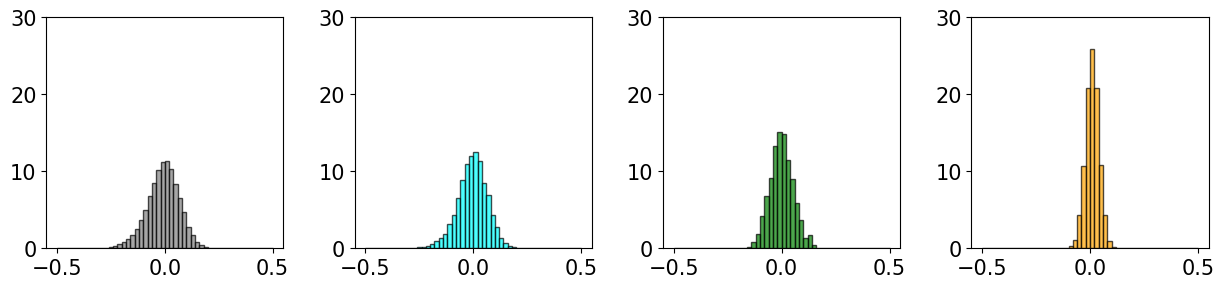

In [87]:
fig1, ax = plt.subplots(1, 4, figsize=(15, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.3)

counts, ed = np.histogram(MKraw_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[0].bar(ed[:-1]+np.diff(ed[:2])/2, counts*2, width = 1/50, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKmpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[1].bar(ed[:-1]+np.diff(ed[:2])/2, counts*2, width = 1/50, color='cyan', alpha=0.7, edgecolor='black', label='measured dist.')

#counts, ed = np.histogram(MKmpca_s_e, bins=50, range=(-0.5, 0.5), density=True)
#cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts*2, width = 1/50, color='magenta', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKgpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts*2, width = 1/50, color='green', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(MKtpca_e, bins=50, range=(-0.5, 0.5), density=True)
cax0 = ax.flat[3].bar(ed[:-1]+np.diff(ed[:2])/2, counts*2, width = 1/50, color='orange', alpha=0.7, edgecolor='black', label='measured dist.')

for ai in range(4):
    ax.flat[ai].set_ylim([0, 30])
    
np.sum(counts*2)

100.0

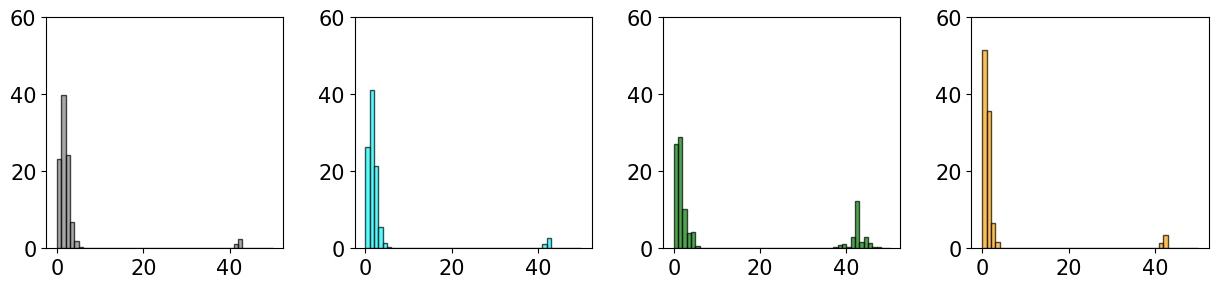

In [91]:
fig1, ax = plt.subplots(1, 4, figsize=(15, 3))
fig1.subplots_adjust(hspace=0.3, wspace=0.3)

counts, ed = np.histogram(AGraw_e, bins=50, range=(0, 50), density=True)
cax0 = ax.flat[0].bar(ed[:-1]+np.diff(ed[:2])/2, counts*100, width = 1, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(AGmpca_e, bins=50, range=(0, 50), density=True)
cax0 = ax.flat[1].bar(ed[:-1]+np.diff(ed[:2])/2, counts*100, width = 1, color='cyan', alpha=0.7, edgecolor='black', label='measured dist.')

#counts, ed = np.histogram(AGmpca_s_e, bins=50, range=(0, 50), density=True)
#cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts*100, width = 1, color='magenta', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(AGgpca_e, bins=50, range=(0, 50), density=True)
cax0 = ax.flat[2].bar(ed[:-1]+np.diff(ed[:2])/2, counts*100, width = 1, color='green', alpha=0.7, edgecolor='black', label='measured dist.')

counts, ed = np.histogram(AGtpca_e, bins=50, range=(0, 50), density=True)
cax0 = ax.flat[3].bar(ed[:-1]+np.diff(ed[:2])/2, counts*100, width = 1, color='orange', alpha=0.7, edgecolor='black', label='measured dist.')

for ai in range(4):
    ax.flat[ai].set_ylim([0, 60])

np.sum(counts*100)

In [92]:
RMSEfa_gpca = np.sqrt(np.mean(FAgpca_e ** 2))
RMSEmd_gpca = np.sqrt(np.mean(MDgpca_e ** 2)) * 1000
RMSErd_gpca = np.sqrt(np.mean(RDgpca_e ** 2)) * 1000
RMSEad_gpca = np.sqrt(np.mean(ADgpca_e ** 2)) * 1000
RMSEmk_gpca = np.sqrt(np.mean(MKgpca_e ** 2))
RMSErk_gpca = np.sqrt(np.mean(RKgpca_e ** 2))
RMSEak_gpca = np.sqrt(np.mean(AKgpca_e ** 2))
    
RMSEfa_tpca = np.sqrt(np.mean(FAtpca_e ** 2))
RMSEmd_tpca = np.sqrt(np.mean(MDtpca_e ** 2)) * 1000
RMSErd_tpca = np.sqrt(np.mean(RDtpca_e ** 2)) * 1000
RMSEad_tpca = np.sqrt(np.mean(ADtpca_e ** 2)) * 1000
RMSEmk_tpca = np.sqrt(np.mean(MKtpca_e ** 2))
RMSErk_tpca = np.sqrt(np.mean(RKtpca_e ** 2))
RMSEak_tpca = np.sqrt(np.mean(AKtpca_e ** 2))

In [93]:
print('GPCA')
print(RMSEfa_gpca)
print(RMSEmd_gpca)
print(RMSErd_gpca)
print(RMSEad_gpca)
print(RMSEmk_gpca)
print(RMSErk_gpca)
print(RMSEak_gpca)
print(' ')
print('TPCA')
print(RMSEfa_tpca)
print(RMSEmd_tpca)
print(RMSErd_tpca)
print(RMSEad_tpca)
print(RMSEmk_tpca)
print(RMSErk_tpca)
print(RMSEak_tpca)

GPCA
0.018398676011127657
0.017438411701410333
0.015769314875552116
0.04772617698060919
0.05411317378021048
0.8221036548625139
0.3180036431745045
 
TPCA
0.01013884172822254
0.007462689362638058
0.007910525932474943
0.026862115967230482
0.03271919880831275
0.15101282533726829
0.19413623449771777
